In [58]:
import pandas as pd
import numpy as np
import datetime
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 700)

In [76]:
# import Gelderman SOD-labeled data
g_data = pd.read_pickle('../data/Gelderman_SOD_cohort/for_pmi_estimation2.pkl')
print(len(g_data))
display(g_data.head())

256


,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,sex_male,month,season_of_recovery,fall,spring,summer,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30,temp_1_3_mean,temp_1_3_std,hum_1_3_mean,hum_1_3_std,temp_4_7_mean,temp_4_7_std,hum_4_7_mean,hum_4_7_std,temp_8_21_mean,temp_8_21_std,hum_8_21_mean,hum_8_21_std,temp_22_56_mean,temp_22_56_std,hum_22_56_mean,hum_22_56_std,temp_57_154_mean,temp_57_154_std,hum_57_154_mean,hum_57_154_std,temp_155_365_mean,temp_155_365_std,hum_155_365_mean,hum_155_365_std
0,004,00400124,2018-01-24,2018-01-09,15.0,77.0,180.0,64.000000,00400124.12.JPG,3.0,00400124.07.JPG,3.0,00400124.10.JPG,3.0,0,01,winter,0,0,0,73.881146,65.115868,32.350972,0.000000,0.000000,0.000000,0.00000,9.315,0.888,71.621,12.679,-3.108,7.418,62.885,6.736,-0.699,6.638,74.493,16.490,4.205,5.889,78.049,14.677,16.426,6.113,76.979,10.014,18.181,7.197,67.221,13.361
1,00b,00b00525,2016-05-25,2016-03-07,79.0,38.0,516.0,73.000039,00b00525.08.JPG,5.0,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0,1,05,spring,0,1,0,1326.323441,1326.323441,1279.608857,983.358857,391.756402,0.000000,0.00000,19.485,0.935,57.198,2.203,18.725,0.697,76.769,8.882,17.617,4.230,64.476,8.287,16.590,4.368,58.561,15.086,7.484,7.232,69.266,15.024,19.483,6.770,74.838,10.009
2,00b,00b00818,2016-08-18,2016-03-07,164.0,38.0,516.0,73.000039,00b00818.07.JPG,6.0,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0,1,08,summer,0,0,1,3552.068684,3552.068684,3505.354100,3209.104100,2617.501645,1785.331086,30.05625,27.174,1.174,71.959,6.483,28.471,0.317,63.152,0.949,26.955,1.031,72.737,6.045,26.864,1.680,67.719,7.432,18.606,5.250,63.088,13.413,12.155,8.104,73.635,12.741
3,00d,00d10116,2019-01-16,2018-11-27,50.0,73.0,235.0,73.000039,00d10116.07.JPG,5.0,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0,1,01,winter,0,0,0,317.835928,268.610789,126.581344,30.420863,0.000000,0.000000,0.00000,3.511,1.705,89.241,11.812,2.666,2.899,57.956,9.740,10.313,2.750,84.482,10.465,5.370,3.923,79.734,12.914,18.516,7.254,81.323,8.885,16.984,8.703,73.738,13.603
4,011,01101210,2018-12-10,2018-11-29,11.0,90.0,170.0,69.000037,01101210.06.JPG,2.0,01101210.03.JPG,2.0,01101210.08.JPG,2.0,0,12,winter,0,0,0,69.692188,54.013368,39.090451,15.414583,0.000000,0.000000,0.00000,3.825,1.623,80.427,17.534,3.942,4.081,64.240,4.184,6.799,5.078,79.896,12.073,10.311,4.085,80.913,11.039,24.042,2.560,80.822,7.902,12.899,9.807,73.032,14.609


In [77]:
# calculate total decomposition score (TDS)
g_data['TDS'] = g_data['true_SOD_G_head']+g_data['true_SOD_G_torso']+g_data['true_SOD_G_limbs']
g_data.head()

,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,sex_male,month,season_of_recovery,fall,spring,summer,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30,temp_1_3_mean,temp_1_3_std,hum_1_3_mean,hum_1_3_std,temp_4_7_mean,temp_4_7_std,hum_4_7_mean,hum_4_7_std,temp_8_21_mean,temp_8_21_std,hum_8_21_mean,hum_8_21_std,temp_22_56_mean,temp_22_56_std,hum_22_56_mean,hum_22_56_std,temp_57_154_mean,temp_57_154_std,hum_57_154_mean,hum_57_154_std,temp_155_365_mean,temp_155_365_std,hum_155_365_mean,hum_155_365_std,TDS
0,004,00400124,2018-01-24,2018-01-09,15.0,77.0,180.0,64.000000,00400124.12.JPG,3.0,00400124.07.JPG,3.0,00400124.10.JPG,3.0,0,01,winter,0,0,0,73.881146,65.115868,32.350972,0.000000,0.000000,0.000000,0.00000,9.315,0.888,71.621,12.679,-3.108,7.418,62.885,6.736,-0.699,6.638,74.493,16.490,4.205,5.889,78.049,14.677,16.426,6.113,76.979,10.014,18.181,7.197,67.221,13.361,9.0
1,00b,00b00525,2016-05-25,2016-03-07,79.0,38.0,516.0,73.000039,00b00525.08.JPG,5.0,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0,1,05,spring,0,1,0,1326.323441,1326.323441,1279.608857,983.358857,391.756402,0.000000,0.00000,19.485,0.935,57.198,2.203,18.725,0.697,76.769,8.882,17.617,4.230,64.476,8.287,16.590,4.368,58.561,15.086,7.484,7.232,69.266,15.024,19.483,6.770,74.838,10.009,13.0
2,00b,00b00818,2016-08-18,2016-03-07,164.0,38.0,516.0,73.000039,00b00818.07.JPG,6.0,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0,1,08,summer,0,0,1,3552.068684,3552.068684,3505.354100,3209.104100,2617.501645,1785.331086,30.05625,27.174,1.174,71.959,6.483,28.471,0.317,63.152,0.949,26.955,1.031,72.737,6.045,26.864,1.680,67.719,7.432,18.606,5.250,63.088,13.413,12.155,8.104,73.635,12.741,15.0
3,00d,00d10116,2019-01-16,2018-11-27,50.0,73.0,235.0,73.000039,00d10116.07.JPG,5.0,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0,1,01,winter,0,0,0,317.835928,268.610789,126.581344,30.420863,0.000000,0.000000,0.00000,3.511,1.705,89.241,11.812,2.666,2.899,57.956,9.740,10.313,2.750,84.482,10.465,5.370,3.923,79.734,12.914,18.516,7.254,81.323,8.885,16.984,8.703,73.738,13.603,13.0
4,011,01101210,2018-12-10,2018-11-29,11.0,90.0,170.0,69.000037,01101210.06.JPG,2.0,01101210.03.JPG,2.0,01101210.08.JPG,2.0,0,12,winter,0,0,0,69.692188,54.013368,39.090451,15.414583,0.000000,0.000000,0.00000,3.825,1.623,80.427,17.534,3.942,4.081,64.240,4.184,6.799,5.078,79.896,12.073,10.311,4.085,80.913,11.039,24.042,2.560,80.822,7.902,12.899,9.807,73.032,14.609,6.0


In [78]:
# natural log transform PMI and ADD
g_data['log_PMI_days'] = np.log(g_data.PMI_days+1)
g_data['log_ADD_thres0'] = np.log(g_data.ADD_thres0+1)
g_data.describe()

,PMI_days,age_at_death,est_weight_lb,est_stature_in,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs,sex_male,fall,spring,summer,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30,temp_1_3_mean,temp_1_3_std,hum_1_3_mean,hum_1_3_std,temp_4_7_mean,temp_4_7_std,hum_4_7_mean,hum_4_7_std,temp_8_21_mean,temp_8_21_std,hum_8_21_mean,hum_8_21_std,temp_22_56_mean,temp_22_56_std,hum_22_56_mean,hum_22_56_std,temp_57_154_mean,temp_57_154_std,hum_57_154_mean,hum_57_154_std,temp_155_365_mean,temp_155_365_std,hum_155_365_mean,hum_155_365_std,TDS,log_PMI_days,log_ADD_thres0
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.00000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,78.871094,63.972656,188.765625,66.945343,3.761719,3.484375,3.472656,0.484375,0.218750,0.324219,0.277344,1150.905508,1123.009439,1039.212466,869.310861,635.165801,265.462488,3.098058,16.418324,1.983098,68.507812,7.601488,16.181133,2.305602,68.755551,8.630770,15.900449,3.352543,69.357027,11.147977,15.093629,3.987012,70.026723,11.897113,13.840684,5.411148,69.840840,12.668477,16.187664,7.22248,71.141344,12.237195,10.718750,3.713757,6.233067
std,87.438959,16.293245,69.435298,3.884366,1.148682,1.058926,1.028627,0.500735,0.414208,0.468999,0.448565,1460.947874,1443.446826,1386.952520,1240.046806,1019.806109,575.830494,13.369336,8.100735,1.426231,11.154685,5.321425,8.079370,1.654926,9.926778,5.331941,7.902068,1.635904,7.773733,4.128593,7.938396,1.613071,5.963854,3.315223,6.975205,1.539247,4.801758,2.512202,4.091097,1.51193,3.593349,1.566577,2.925044,1.281490,1.425379
min,0.000000,26.000000,93.000000,59.000032,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.735417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.121000,0.124000,38.323000,0.297000,-5.316000,0.208000,46.812000,0.593000,-1.662000,0.898000,49.971000,2.979000,0.534000,1.167000,56.909000,5.716000,3.417000,1.657000,60.149000,7.029000,8.330000,4.08000,63.527000,9.650000,4.000000,0.000000,0.551248
25%,15.000000,53.750000,135.000000,64.000035,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,224.541773,207.786198,144.396119,80.000955,0.000000,0.000000,0.000000,10.769000,0.887750,61.679750,3.368250,10.026750,1.009000,61.607000,4.341000,8.761000,1.920000,62.637250,7.858750,7.705750,2.631250,65.753500,9.116500,7.736000,4.602250,66.451000,10.847750,12.502750,5.98875,68.867000,10.974000,9.000000,2.772589,5.418413
50%,47.500000,63.000000,180.000000,67.000036,4.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,565.709945,527.853068,463.586597,325.678423,125.220799,0.000000,0.000000,17.849500,1.623500,68.876500,6.564000,17.940000,1.858500,69.642500,7.613000,16.287500,3.128000,69.967500,10.790500,15.408500,4.068000,70.663500,11.680000,13.421500,5.712500,69.991500,12.965000,16.767500,7.35750,71.411500,12.165000,11.000000,3.881511,6.339703
75%,106.750000,76.000000,233.250000,70.000000,5.000000,4.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1247.915797,1214.307633,1202.876067,1013.331716,801.204321,236.971042,0.000000,23.288250,2.744750,77.279500,10.458500,23.233000,3.016250,76.562000,12.354000,23.169500,4.474750,75.992250,14.412250,22.950500,5.057500,74.281750,14.746250,20.726000,6.537500,72.741000,14.787500,20.014250,8.56325,74.132250,13.431000,12.000000,4.679742,7.130029
max,353.000000,96.000000,516.000000,77.000042,6.000000,6.000000,6.000000,1.000000,1.000000,1.000000,1.000000,5889.655055,5797.420345,5540.646377,4779.720588,3934.570925,2371.437128,126.045139,29.529000,7.186000,93.632000,27.439000,29.107000,9.172000,88.449000,28.526000,27.644000,9.247000

In [79]:
# drop unneeded columns 
g_data2 = g_data[['TDS', 'PMI_days', 'log_PMI_days', 'age_at_death', 'sex_male','est_weight_lb', 'est_stature_in',
       'true_SOD_G_head', 'true_SOD_G_torso', 'true_SOD_G_limbs', 
       'fall', 'spring', 'summer', 'log_ADD_thres0', 'ADD_thres0',
       'ADD_thres5', 'ADD_thres10', 'ADD_thres15', 'ADD_thres20',
       'ADD_thres25', 'ADD_thres30', 'temp_1_3_mean', 'temp_1_3_std',
       'hum_1_3_mean', 'hum_1_3_std', 'temp_4_7_mean', 'temp_4_7_std',
       'hum_4_7_mean', 'hum_4_7_std', 'temp_8_21_mean', 'temp_8_21_std',
       'hum_8_21_mean', 'hum_8_21_std', 'temp_22_56_mean', 'temp_22_56_std',
       'hum_22_56_mean', 'hum_22_56_std', 'temp_57_154_mean',
       'temp_57_154_std', 'hum_57_154_mean', 'hum_57_154_std',
       'temp_155_365_mean', 'temp_155_365_std', 'hum_155_365_mean',
       'hum_155_365_std']].copy()

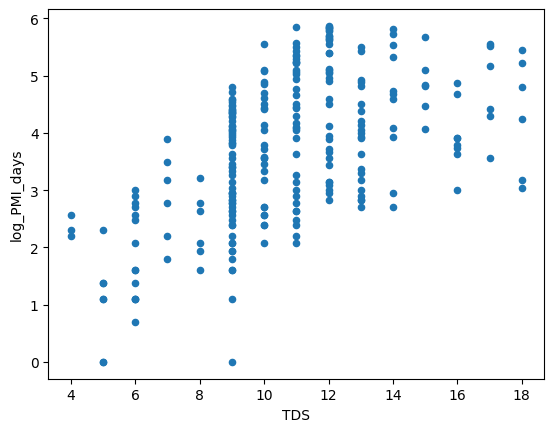

In [80]:
g_data2.plot.scatter(x = 'TDS', y = 'log_PMI_days', logy=False)
plt.show()

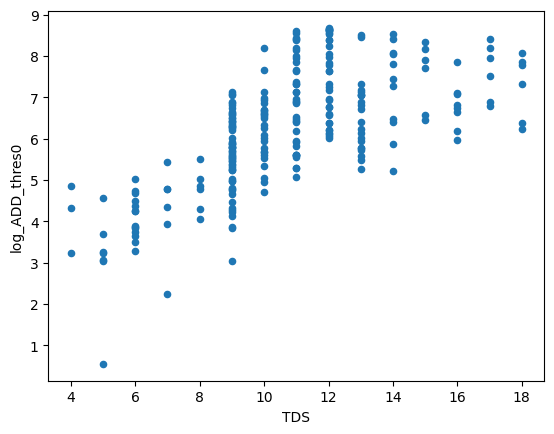

In [81]:
g_data2.plot.scatter(x = 'TDS', y = 'log_ADD_thres0', logy=False)
plt.show()

In [82]:
# remove rows
g_data3 = g_data2.copy()
g_data3.drop([95, 129, 162, 163, 226], inplace=True)

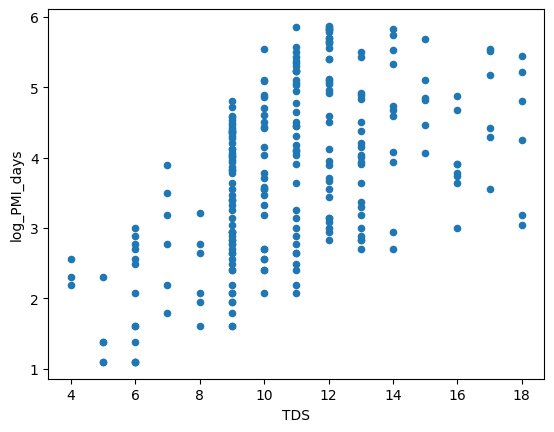

In [83]:
g_data3.plot.scatter(x = 'TDS', y = 'log_PMI_days', logy=False)
plt.show()

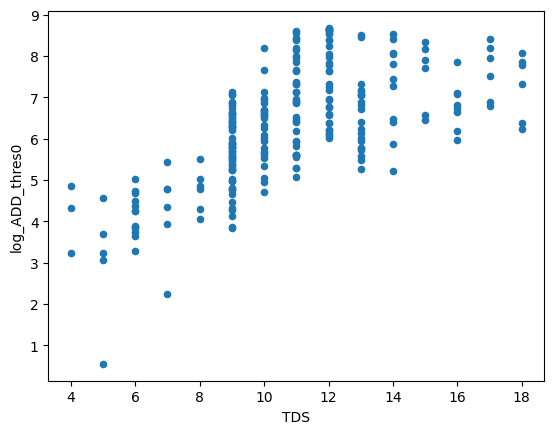

In [84]:
g_data3.plot.scatter(x = 'TDS', y = 'log_ADD_thres0', logy=False)
plt.show()

In [85]:
# remove rows
g_data4 = g_data3.copy()
g_data4.drop([15, 24], inplace=True)

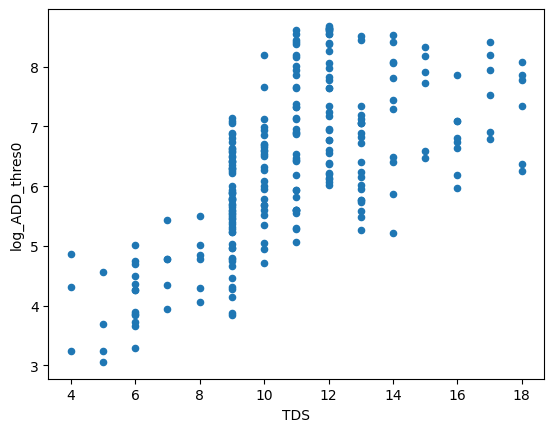

In [86]:
g_data4.plot.scatter(x = 'TDS', y = 'log_ADD_thres0', logy=False)
plt.show()

In [87]:
# create BMI
def bmi_imperial(weight_lb, height_in):
    if height_in != 0: 
        bmi = round(703*(weight_lb/(height_in**2)), 1)
    else:
        bmi = np.nan
    return bmi

def bmi_status(bmi):
    if bmi < 18.5:
        status = 'underweight'
    elif 18.5 <= bmi <= 24.9:
        status = 'healthy'
    elif 24.9 < bmi <= 29.9:
        status = 'overweight'
    elif bmi > 29.9:
        status = 'obese'
    elif pd.isna(bmi):
        status = float('nan')
    return status

# add BMI and BMI_status column
g_data4['BMI'] = g_data4.apply(lambda x: bmi_imperial(x['est_weight_lb'], x['est_stature_in'])
                                               , axis=1)
g_data4['BMI_status'] = g_data4.apply(lambda x: bmi_status(x['BMI']), axis=1)
display(g_data4.head())

,TDS,PMI_days,log_PMI_days,age_at_death,sex_male,est_weight_lb,est_stature_in,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs,fall,spring,summer,log_ADD_thres0,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30,temp_1_3_mean,temp_1_3_std,hum_1_3_mean,hum_1_3_std,temp_4_7_mean,temp_4_7_std,hum_4_7_mean,hum_4_7_std,temp_8_21_mean,temp_8_21_std,hum_8_21_mean,hum_8_21_std,temp_22_56_mean,temp_22_56_std,hum_22_56_mean,hum_22_56_std,temp_57_154_mean,temp_57_154_std,hum_57_154_mean,hum_57_154_std,temp_155_365_mean,temp_155_365_std,hum_155_365_mean,hum_155_365_std,BMI,BMI_status
0,9.0,15.0,2.772589,77.0,0,180.0,64.000000,3.0,3.0,3.0,0,0,0,4.315902,73.881146,65.115868,32.350972,0.000000,0.000000,0.000000,0.00000,9.315,0.888,71.621,12.679,-3.108,7.418,62.885,6.736,-0.699,6.638,74.493,16.490,4.205,5.889,78.049,14.677,16.426,6.113,76.979,10.014,18.181,7.197,67.221,13.361,30.9,obese
1,13.0,79.0,4.382027,38.0,1,516.0,73.000039,5.0,5.0,3.0,0,1,0,7.190920,1326.323441,1326.323441,1279.608857,983.358857,391.756402,0.000000,0.00000,19.485,0.935,57.198,2.203,18.725,0.697,76.769,8.882,17.617,4.230,64.476,8.287,16.590,4.368,58.561,15.086,7.484,7.232,69.266,15.024,19.483,6.770,74.838,10.009,68.1,obese
2,15.0,164.0,5.105945,38.0,1,516.0,73.000039,6.0,6.0,3.0,0,0,1,8.175567,3552.068684,3552.068684,3505.354100,3209.104100,2617.501645,1785.331086,30.05625,27.174,1.174,71.959,6.483,28.471,0.317,63.152,0.949,26.955,1.031,72.737,6.045,26.864,1.680,67.719,7.432,18.606,5.250,63.088,13.413,12.155,8.104,73.635,12.741,68.1,obese
3,13.0,50.0,3.931826,73.0,1,235.0,73.000039,5.0,4.0,4.0,0,0,0,5.764677,317.835928,268.610789,126.581344,30.420863,0.000000,0.000000,0.00000,3.511,1.705,89.241,11.812,2.666,2.899,57.956,9.740,10.313,2.750,84.482,10.465,5.370,3.923,79.734,12.914,18.516,7.254,81.323,8.885,16.984,8.703,73.738,13.603,31.0,obese
4,6.0,11.0,2.484907,90.0,0,170.0,69.000037,2.0,2.0,2.0,0,0,0,4.258335,69.692188,54.013368,39.090451,15.414583,0.000000,0.000000,0.00000,3.825,1.623,80.427,17.534,3.942,4.081,64.240,4.184,6.799,5.078,79.896,12.073,10.311,4.085,80.913,11.039,24.042,2.560,80.822,7.902,12.899,9.807,73.032,14.609,25.1,overweight


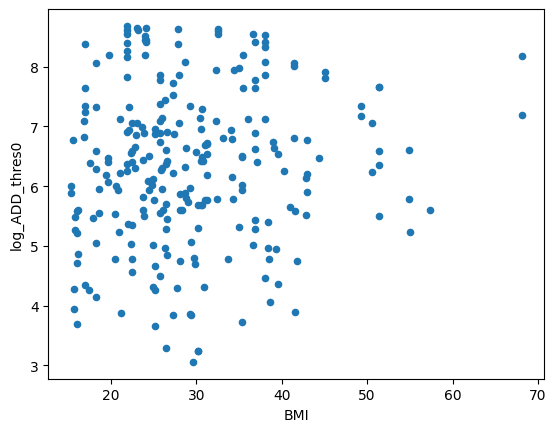

In [88]:
g_data4.plot.scatter(x = 'BMI', y = 'log_ADD_thres0', logy=False)
plt.show()

In [89]:
g_data4.describe()

,TDS,PMI_days,log_PMI_days,age_at_death,sex_male,est_weight_lb,est_stature_in,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs,fall,spring,summer,log_ADD_thres0,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30,temp_1_3_mean,temp_1_3_std,hum_1_3_mean,hum_1_3_std,temp_4_7_mean,temp_4_7_std,hum_4_7_mean,hum_4_7_std,temp_8_21_mean,temp_8_21_std,hum_8_21_mean,hum_8_21_std,temp_22_56_mean,temp_22_56_std,hum_22_56_mean,hum_22_56_std,temp_57_154_mean,temp_57_154_std,hum_57_154_mean,hum_57_154_std,temp_155_365_mean,temp_155_365_std,hum_155_365_mean,hum_155_365_std,BMI
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,10.835341,81.032129,3.796573,63.811245,0.489960,189.554217,66.991998,3.811245,3.518072,3.506024,0.224900,0.325301,0.273092,6.328518,1182.565102,1153.921953,1067.769242,893.091287,652.652290,272.824201,3.185152,16.510225,1.973000,68.423442,7.579651,16.247811,2.302859,68.840221,8.544285,15.888000,3.352755,69.310566,11.214076,15.166221,3.973386,70.082908,11.865406,13.909044,5.384145,69.802233,12.651008,16.150410,7.198438,71.151297,12.246574,29.460241
std,2.866836,87.690892,1.191370,16.097501,0.500906,69.672709,3.913513,1.118266,1.051437,1.016479,0.418357,0.469431,0.446445,1.312086,1468.944379,1451.636283,1395.699539,1249.136530,1028.647638,582.192175,13.546427,8.011245,1.415787,11.101837,5.298932,8.015351,1.655549,9.858375,5.348772,7.897611,1.635434,7.765087,4.132659,7.952929,1.620926,6.007957,3.342319,7.023522,1.542990,4.789429,2.477489,4.119763,1.503085,3.548865,1.564935,9.700968
min,4.000000,2.000000,1.098612,26.000000,0.000000,93.000000,59.000032,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.059717,20.321528,16.846458,0.000000,0.000000,0.000000,0.000000,0.000000,-7.121000,0.124000,38.323000,0.297000,-5.316000,0.208000,46.812000,0.593000,-1.662000,0.898000,49.971000,2.979000,0.534000,1.167000,56.909000,5.716000,3.417000,1.657000,60.149000,7.029000,8.330000,4.080000,63.527000,9.650000,15.300000
25%,9.000000,16.000000,2.833213,54.000000,0.000000,136.000000,64.000035,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,5.505174,244.961131,228.585372,177.622500,87.119816,0.000000,0.000000,0.000000,10.867000,0.888000,61.719000,3.377000,10.064000,1.009000,61.622000,4.299000,8.764000,1.924000,62.539000,7.872000,7.738000,2.617000,65.656000,9.054000,7.586000,4.479000,66.451000,10.849000,12.403000,5.943000,68.876000,10.974000,22.500000
50%,11.000000,49.000000,3.912023,63.000000,0.000000,180.000000,67.000036,4.000000,3.000000,3.000000,0.000000,0.000000,0.000000,6.380610,589.287550,579.033137,470.084851,336.388383,163.529435,0.000000,0.000000,18.032000,1.623000,68.840000,6.553000,17.994000,1.858000,69.539000,7.379000,16.118000,3.120000,69.979000,10.834000,15.535000,4.054000,70.761000,11.658000,13.535000,5.703000,69.983000,12.911000,16.717000,7.337000,71.414000,12.196000,27.400000
75%,12.000000,111.000000,4.718499,75.000000,1.000000,234.000000,70.000000,5.000000,4.000000,4.000000,0.000000,1.000000,1.000000,7.141903,1262.831388,1251.158819,1206.436840,1034.212103,868.199861,238.618681,0.000000,23.367000,2.744000,77.180000,10.496000,23.233000,3.014000,76.658000,12.313000,23.160000,4.483000,75.980000,14.520000,23.178000,5.057000,74.323000,14.759000,20.831000,6.527000,72.544000,14.774000,19.997000,8.488000,74.128000,13.420000,35.400000
max,18.000000,353.000000,5.869297,96.000000,1.000000,516.000000,77.000042,6.000000,6.000000,6.000000,1.000000,1.000000,1.000000,8.681122,5889.655055,5797.420345,5540.646377,4779.720588,3934.570925,2371.437

In [91]:
# save processed data 
g_data4.to_pickle('./data_max_1year')

In [92]:
g_data4[g_data4['PMI_days'] < 183].to_pickle('./data_max_6months')

In [93]:
g_data4[g_data4['PMI_days'] < 92].to_pickle('./data_max_3months')